In [2]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

train['is_train'] = True
test['is_train'] = False

print("length of training set = {:d} observations".format(len(train)))
print("length of testing set = {:d} observations".format(len(test)))

data = pd.concat((train,test)).reset_index(drop=True)

assert len(data) == len(train) + len(test)
print("correctly concatenated train and test data  =>  num. observations = {:d}".format(len(data)))

data_features = data.drop(['Response', 'is_train'], axis=1)

length of training set = 59381 observations
length of testing set = 19765 observations
correctly concatenated train and test data  =>  num. observations = 79146


## List the features that have null values:

In [5]:
features_with_nulls = {k:v for k, v in data_features.isnull().apply(sum).to_dict().items() if v > 0}
features_with_nulls

{'Employment_Info_1': 22,
 'Employment_Info_4': 8916,
 'Employment_Info_6': 14641,
 'Family_Hist_2': 38536,
 'Family_Hist_3': 45305,
 'Family_Hist_4': 25861,
 'Family_Hist_5': 55435,
 'Insurance_History_5': 33501,
 'Medical_History_1': 11861,
 'Medical_History_10': 78388,
 'Medical_History_15': 59460,
 'Medical_History_24': 74165,
 'Medical_History_32': 77688}

In [81]:
def loosen_limits(ax, which='x'):
    if which == 'x' or which == 'xy':
        x0, x1 = ax.get_xlim()
        xr = x1 - x0
        ax.set_xlim(x0 - 0.05 *xr, x1 + 0.05 * xr)
    elif  which == 'y' or which == 'xy':
        y0, y1 = ax.get_ylim()
        yr = y1 - y0
        ax.set_ylim(y0 - 0.05 *yr, y1 + 0.05 * yr)
    
def make_hist(df, cols, ylog=False):
    ysize = (len(cols) // 5 + 1) * 3.
    ax = df[cols].hist(figsize=(16,ysize), bins=50, sharex=False, layout=(-1,5))
    for axes in ax.flat:
        loosen_limits(axes)
        name = axes.get_title()
        if name == '':
            continue
        
        axes.set_title("{} [{:d}]".format(name, df[name].count()), fontsize=10)
        if ylog:
            axes.set_yscale('log')
        
def make_hexbin(df, col):
    ax = df.plot(kind='hexbin', x=col, y='Response', sharex=False, gridsize=25, norm=matplotlib.colors.PowerNorm(1/2))
    ax.set_ylim(0., 9)
    loosen_limits(ax)
    ax.set_title(col, fontsize=10)
    return ax

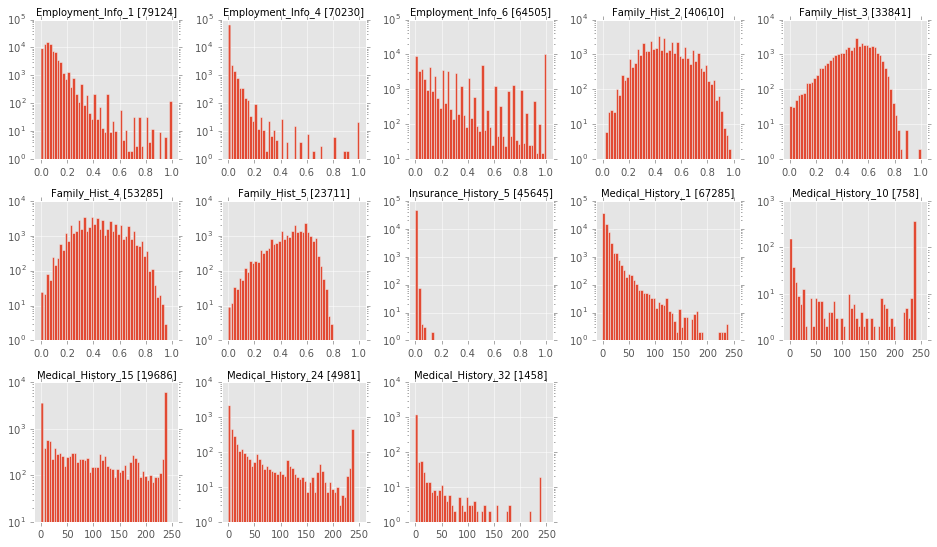

In [82]:
na_cols = list(features_with_nulls.keys())
make_hist(data_features, na_cols, ylog=True)

# Analyze each of the features that have null values


## Employment_Info 1, 6 

These ones will be imputed with median value, since there are not that many NAs

## Family_Hist 2, 3, 4, 5 

These ones will be imputed with the median, and a new isNA? dummy column will be created for each.   Will do this since the number of NAs is a good fraction of the total data. 

## Insurance_History_5

This one is examined in more detail below.  It will be dropped from the analysis. 

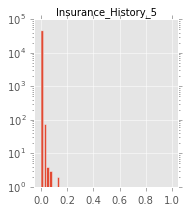

In [60]:
make_hist(data_features, ['Insurance_History_5'], ylog=True)

In [61]:
data_features['Insurance_History_5'].describe()

count    45645.000000
mean         0.001710
std          0.006465
min          0.000000
25%          0.000400
50%          0.000933
75%          0.002000
max          1.000000
Name: Insurance_History_5, dtype: float64

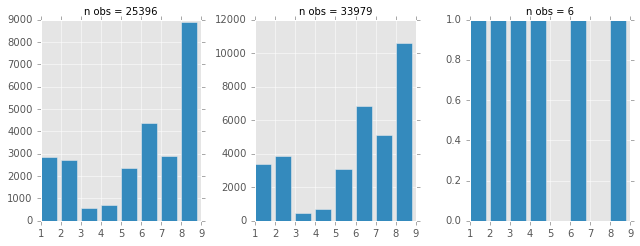

In [97]:
nulls = train[train['Insurance_History_5'].isnull()]['Response']
lo = train[train['Insurance_History_5'] < 0.05]['Response']
hi = train[train['Insurance_History_5'] >= 0.05]['Response']

fig, ax = plt.subplots(1,3, figsize=(9., 3.5))
for i,s in enumerate([nulls, lo, hi]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()


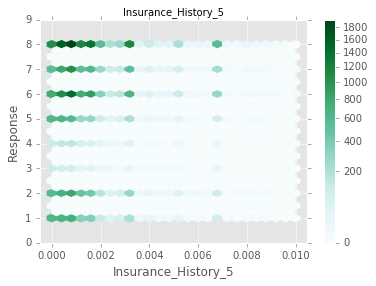

In [47]:
make_hexbin(train[train['Insurance_History_5'] < 0.01], 'Insurance_History_5')

Conclusion, will drop this feature from the data

## Medical_History_1 

Will be imputed with median

## Medical_History_10

This one will be converted into three dummy variables: 

1. is null?
2. is not null and < 200?
3. is not null and >= 200?


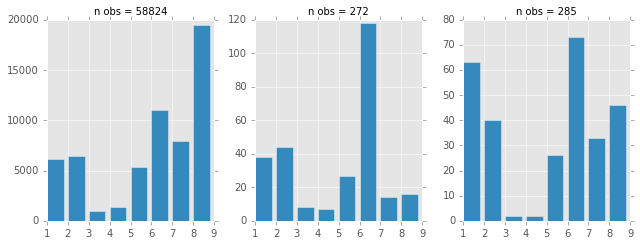

In [105]:
nulls = train[train['Medical_History_10'].isnull()]['Response']
nonull1 = train[(~train['Medical_History_10'].isnull()) & (train['Medical_History_10'] < 200) ]['Response']
nonull2 = train[(~train['Medical_History_10'].isnull()) & (train['Medical_History_10'] >= 200) ]['Response']

fig, ax = plt.subplots(1,3, figsize=(9., 3.5))
for i,s in enumerate([nulls, nonull1, nonull2]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

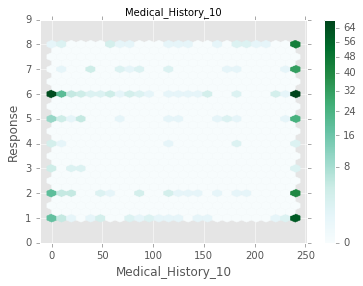

In [98]:
make_hexbin(train[~train['Medical_History_10'].isnull()], 'Medical_History_10')

## Medical_History_15

This one will be replaced with 4 dummies: 

1.  is null?
2.  not null and < 12
3.  not null and >=12 and < 200 
4.  not null and >= 200 

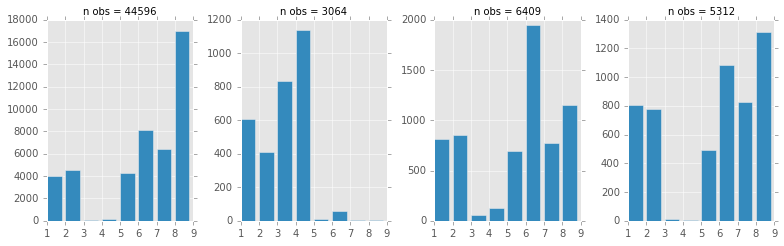

In [124]:
nulls = train[train['Medical_History_15'].isnull()]['Response']
nonull0 = train[(~train['Medical_History_15'].isnull()) &
                (train['Medical_History_15']< 12)]['Response']
nonull1 = train[(~train['Medical_History_15'].isnull()) &
                (train['Medical_History_15'] >= 12) &
                (train['Medical_History_15'] < 200) ]['Response']
nonull2 = train[(~train['Medical_History_15'].isnull()) & (train['Medical_History_15'] >= 200) ]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1, nonull2]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

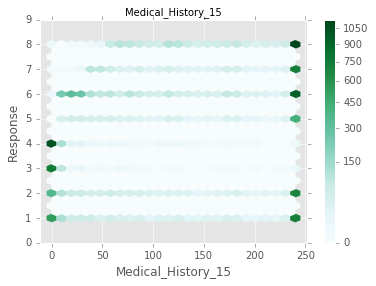

In [107]:
make_hexbin(train[~train['Medical_History_15'].isnull()], 'Medical_History_15')

## Medical_History 24

This one will be replaced with 3 dummies:

1. is null?
2. not null and < 25
3. not null and >= 25

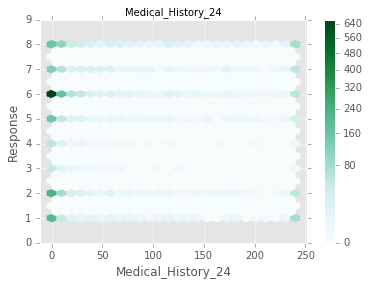

In [125]:
make_hexbin(train[~train['Medical_History_24'].isnull()], 'Medical_History_24')

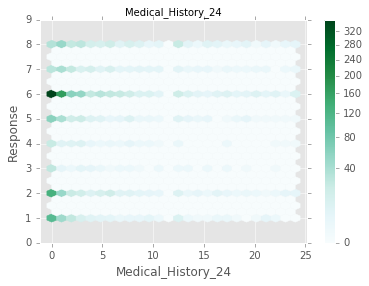

In [131]:
make_hexbin(train[train['Medical_History_24'] < 25], 'Medical_History_24')

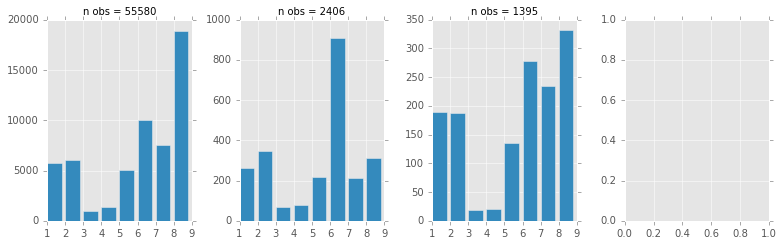

In [130]:
name = 'Medical_History_24'

nulls = train[train[name].isnull()]['Response']
nonull0 = train[(~train[name].isnull()) &
                (train[name]< 25)]['Response']
nonull1 = train[(~train[name].isnull()) &
                (train[name] >= 25)]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

## Medical_History_32

This one will be replaced with 3 dummies:

1. is null?
2. not null and < 100
3. not null and >= 100

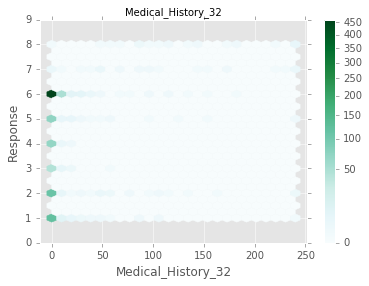

In [132]:
make_hexbin(train[~train['Medical_History_32'].isnull()], 'Medical_History_32')

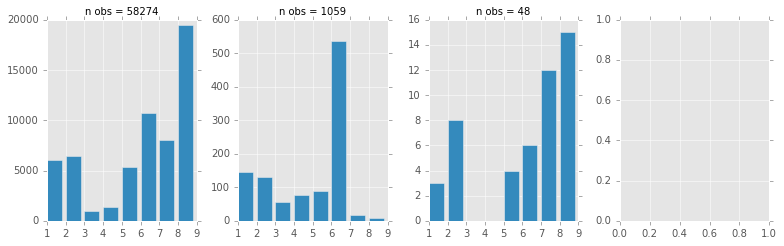

In [134]:
name = 'Medical_History_32'

nulls = train[train[name].isnull()]['Response']
nonull0 = train[(~train[name].isnull()) &
                (train[name]< 100)]['Response']
nonull1 = train[(~train[name].isnull()) &
                (train[name] >= 100)]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

## Employment_Info_4 

This one will be dropped.  Most of the values are 0. 

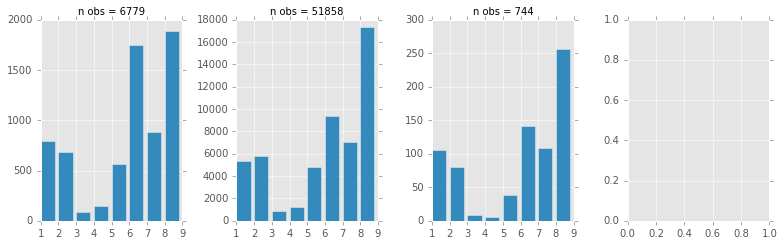

In [155]:
name = 'Employment_Info_4'

nulls = train[train[name].isnull()]['Response']
nonull0 = train[(~train[name].isnull()) &
                (train[name]< 0.1)]['Response']
nonull1 = train[(~train[name].isnull()) &
                (train[name] >= 0.1)]['Response']

fig, ax = plt.subplots(1,4, figsize=(11., 3.5))
for i,s in enumerate([nulls, nonull0, nonull1]):
    cts = s.value_counts()
    ax[i].bar(cts.index, cts.values)
    ax[i].set_title("n obs = {:d}".format(len(s)), fontsize=10)
fig.tight_layout()

# Non-numerical features


The only non-numerical feature is Product_Info_2.  We will go ahead and replace it with dummies.

In [239]:
# Print a dictionary with the features that are find to be non-numerical: 

nonnum = {col: data_features.dtypes[col] 
          for col in data_features.columns 
              if data_features.dtypes[col] not in [np.dtype('int64'), np.dtype('float64')]}
print("non-mumerical columns = {}".format(nonnum))

non-mumerical columns = {'Product_Info_2': dtype('O')}


In [221]:
train['Product_Info_2'].value_counts()

D3    14321
D4    10812
A8     6835
D1     6554
D2     6286
E1     2647
A1     2363
A6     2098
A2     1974
A7     1383
B2     1122
A3      977
A5      775
C3      306
C1      285
C4      219
A4      210
C2      160
B1       54
Name: Product_Info_2, dtype: int64

In [232]:
train['Product_Info_2'].factorize()

(array([0, 1, 2, ..., 2, 4, 5]),
 Index(['D3', 'A1', 'E1', 'D4', 'D2', 'A8', 'A2', 'D1', 'A7', 'A6', 'A3', 'A5',
        'C4', 'C1', 'B2', 'C3', 'C2', 'A4', 'B1'],
       dtype='object'))

In [230]:
pi2_factor = pd.Series(pd.factorize(train['Product_Info_2'])[0], index=train.index, name='PI2_factor')
tempdf = pd.concat([pi2_factor, train['Response']], axis=1)
tempdf.head()

,PI2_factor,Response
0,0,8
1,1,4
2,2,8
3,3,8
4,4,8


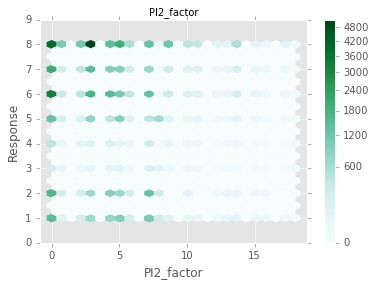

In [233]:
make_hexbin(tempdf, 'PI2_factor')

# Imputing the missing values v2

Notice that I tried to use this imputations, as opposed to just filling all the NA's with a value of -1.  In the case of using xgboost, the value of -1 was just fine.  The imputations described here would me more appropriate if one were to be using a linear model. 

In [238]:
dummies = pd.get_dummies(train['Product_Info_2']).head()
dummies

,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,C1,C2,C3,C4,D1,D2,D3,D4,E1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [242]:
add_isna_dummy = [
    'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5',
    'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32'
]

fill_median = [
    'Employment_Info_1', 'Employment_Info_6',
    'Medical_History_1', 'Family_Hist_2', 'Family_Hist_3', 'Family_Hist_4', 'Family_Hist_5'
    ]

# The inrange dummies will be added by hand:
#
# add_inrange = {
#    'Medical_History_10': ['<200', '>=200'],
#    'Medical_History_15': ['<12', '>=12, <200', '>=200'],
#    'Medical_History_24': ['<25', '>=25'],
#    'Medical_History_32': ['<100', '>=100'],
#}

to_drop = [
    'Employment_Info_4', 'Insurance_History_5',
    'Medical_History_10', 'Medical_History_15', 'Medical_History_24', 'Medical_History_32',
    'Product_Info_2'
]

def impute_missing(mysample):

    # 1. Add isNA dummies:
    mysample01 = mysample.join(pd.isnull(mysample[add_isna_dummy]).astype(int), rsuffix='_isNA')

    # 2. Impute with median:
    mysample02 = mysample01.fillna(mysample01[fill_median].median())

    # 3. Add in range dummies: 
    imputed = []
    name = 'Medical_History_10'
    imputed.append(name)
    col = mysample02[name]
    newA1 = pd.Series(col < 200, name = name + '_01').astype(int)
    newA2 = pd.Series(col >= 200, name = name + '_02').astype(int)

    name = 'Medical_History_15'
    imputed.append(name)
    col = mysample02[name]
    newB1 = pd.Series(col < 12, name = name + '_01').astype(int)
    newB2 = pd.Series((col >= 12) & (col < 200), name = name + '_02').astype(int)
    newB3 = pd.Series(col >= 200, name = name + '_03').astype(int)

    name = 'Medical_History_24'
    imputed.append(name)
    col = mysample02[name]
    newC1 = pd.Series(col < 25, name = name + '_01').astype(int)
    newC2 = pd.Series(col >= 25, name = name + '_02').astype(int)

    name = 'Medical_History_32'
    imputed.append(name)
    col = mysample02[name]
    newD1 = pd.Series(col < 100, name = name + '_01').astype(int)
    newD2 = pd.Series(col >= 100, name = name + '_02').astype(int)

    new = pd.concat([newA1, newA2, newB1, newB2, newB3, newC1, newC2, newD1, newD2], axis=1)
    mysample03 = mysample02.join(new)
    
    # 4. Replace categorical with dummies
    dummies = pd.get_dummies(mysample03['Product_Info_2'])
    mysample04 = mysample03.join(dummies)

    # 4. Drop features
    mysample05 = mysample04.drop(to_drop, axis=1)
    
    return mysample05


    
cols = list(features_with_nulls)
mysample = train[cols]
mysample.head()

,Employment_Info_6,Medical_History_32,Employment_Info_4,Medical_History_15,Family_Hist_4,Employment_Info_1,Medical_History_10,Insurance_History_5,Family_Hist_2,Medical_History_24,Family_Hist_5,Medical_History_1,Family_Hist_3
0,NaN,NaN,0,240,NaN,0.028,NaN,0.000667,NaN,NaN,0.526786,4,0.598039
1,0.0018,NaN,0,0,0.084507,0.000,NaN,0.000133,0.188406,NaN,NaN,5,NaN
2,0.0300,NaN,0,NaN,0.225352,0.030,NaN,NaN,0.304348,NaN,NaN,10,NaN
3,0.2000,NaN,0,NaN,0.352113,0.042,NaN,NaN,0.420290,NaN,NaN,0,NaN
4,0.0500,NaN,0,NaN,0.408451,0.027,NaN,NaN,0.463768,NaN,NaN,NaN,NaN


In [249]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

train['is_train'] = True
test['is_train'] = False

data = pd.concat((train,test)).reset_index(drop=True)

data_imputed = impute_missing(data)
data_imputed.to_csv('csvs/data_imputed_v2.csv', index=False)

In [250]:
# Verify that there are no NAs left:
print("columns with NAs: ", 
      {k:v for k, v in data_imputed.isnull().apply(sum).to_dict().items() if v > 0})

# Verify that there are no non-numeric features left:
nonnum = {col: data_imputed.dtypes[col] 
          for col in data_imputed.columns 
              if data_imputed.dtypes[col] not in [np.dtype('int64'), np.dtype('float64')]}
print("non-mumerical columns = {}".format(nonnum))

columns with NAs:  {'Response': 19765}
non-mumerical columns = {'is_train': dtype('bool')}


In [252]:
data_imputed.head()

,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_5,Employment_Info_6,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Ht,Id,Ins_Age,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Medical_History_1,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_2,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_3,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_4,Medical_History_40,Medical_History_41,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_Keyword_1,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_2,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_3,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_4,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Product_Info_1,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Response,Wt,is_train,Family_Hist_2_isNA,Family_Hist_3_isNA,Family_Hist_4_isNA,Family_Hist_5_isNA,Medical_History_10_isNA,Medical_History_15_isNA,Medical_History_24_isNA,Medical_History_32_isNA,Medical_History_10_01,Medical_History_10_02,Medical_History_15_01,Medical_History_15_02,Medical_History_15_03,Medical_History_24_01,Medical_History_24_02,Medical_History_32_01,Medical_History_32_02,A1,A2,A3,A4,A5,A6,A7,A8,B1,B2,C1,C2,C3,C4,D1,D2,D3,D4,E1
0,0.323008,0.028,12,1,3,0.2500,2,0.463768,0.598039,0.436620,0.526786,0.581818,2,0.641791,1,1,3,1,1,1,2,1,2,6,3,1,2,1,4,3,2,3,3,3,3,1,1,112,2,1,2,3,1,3,3,1,3,2,2,3,1,3,1,2,2,1,3,1,3,3,1,3,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,0.076923,2,1,1,8,0.148536,True,1,0,1,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.272288,0.000,1,3,2,0.0018,2,0.188406,0.519608,0.084507,0.508929,0.600000,5,0.059701,2,1,3,1,1,3,2,1,2,6,3,1,2,1,5,3,2,3,3,1,3,1,1,412,2,1,2,3,1,3,3,1,3,2,2,3,3,1,1,2,2,1,3,1,3,1,1,3,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0.076923,2,3,1,4,0.131799,True,0,1,0,1,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.428780,0.030,9,1,2,0.0300,3,0.304348,0.519608,0.225352,0.508929,0.745455,6,0.029851,2,1,1,3,3,2,3,1,2,8,3,1,1,1,10,3,2,3,3,1,3,1,1,3,2,1,2,3,2,2,3,1,3,2,2,3,3,3,1,3,2,1,3,2,3,1,1,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,26,0.076923,2,3,1,8,0.288703,True,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0.352438,0.042,9,1,3,0.2000,3,0.420290,0.519608,0.352113,0.508929,0.672727,7,0.164179,2,1,1,3,3,2,3,2,2,8,3,1,2,1,0,3,2,3,3,1,3,1,1,350,2,2,2,3,1,3,3,1,3,2,2,3,3,3,1,2,2,1,3,2,3,1,1,3,2,2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,

In [254]:
print(len(data_imputed))
print(data_imputed['Id'].nunique())

79146
79146


# Imputing the missing  values v1

This is a simple imputation where all NAs are replaced by -1.  Works well when using xgboost. 

In [3]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

train['train?'] = True
test['train?'] = False

data = pd.concat((train,test)).reset_index(drop=True)

noprod = data.drop(['Product_Info_2'], axis=1)
dummies = pd.get_dummies(data['Product_Info_2'])

df = noprod.join(dummies).drop(['Response', 'train?'], axis=1).fillna(-1).join(data[['Response', 'train?']])
df.to_csv('csvs/data_imputed.csv', index=False)